In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import glob
import os
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set your data path
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Preprocessed/"

# Check all files in the directory
import os
all_files = os.listdir(DATA_PATH)
print("All files in directory:")
for f in all_files:
    print(f" - {f}")

# Filter for CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]
print(f"\nFound {len(csv_files)} CSV files:")
for f in csv_files:
    print(f" - {f}")

In [ ]:
def load_all_patients_data(data_path, csv_files):

    patients_data = {}

    for filename in csv_files:
        try:
            filepath = os.path.join(data_path, filename)

            # Extract patient number from filename
            patient_num_str = filename.replace('HUPA', '').replace('P.csv', '').replace('.csv', '').lstrip('0')
            patient_num = int(patient_num_str) if patient_num_str else 1

            # Load with proper semicolon separation
            df = pd.read_csv(filepath, sep=';')


            # Convert time column to datetime
            df['time'] = pd.to_datetime(df['time'], errors='coerce')

            # Drop rows with invalid time
            df = df.dropna(subset=['time'])

            # Sort by time
            df = df.sort_values('time').reset_index(drop=True)

            # Convert numeric columns to appropriate types
            numeric_columns = ['glucose', 'calories', 'heart_rate', 'steps',
                             'basal_rate', 'bolus_volume_delivered', 'carb_input']

            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            patients_data[patient_num] = df

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

    print(f"\nSuccessfully loaded {len(patients_data)} patients")
    return patients_data

# Load all patient data with proper semicolon separation
all_patients = load_all_patients_data(DATA_PATH, csv_files)

In [ ]:
if all_patients:
    first_patient_id = list(all_patients.keys())[0]
    first_patient_data = all_patients[first_patient_id]

    print("First patient data shape:", first_patient_data.shape)
    print("\nColumns:", first_patient_data.columns.tolist())
    print("\nFirst few rows:")
    display(first_patient_data.head(10))

    # Data info
    print("\nData types:")
    print(first_patient_data.dtypes)

    # Check for missing values
    print("\nMissing values per column:")
    print(first_patient_data.isnull().sum())

    # Check time range and frequency
    print(f"\nTime range: {first_patient_data['time'].min()} to {first_patient_data['time'].max()}")
    time_diff = first_patient_data['time'].diff().mean()
    print(f"Average time difference: {time_diff}")

    # Basic statistics
    print("\nBasic statistics:")
    display(first_patient_data.describe())

else:
    print("No patients loaded. Let's debug the file structure...")

    # Debug: Check raw file content
    if csv_files:
        sample_file = os.path.join(DATA_PATH, csv_files[0])
        print(f"\nDebugging file: {csv_files[0]}")

        # Read raw file content
        with open(sample_file, 'r') as f:
            lines = f.readlines()

        print("First 3 lines of raw file:")
        for i, line in enumerate(lines[:3]):
            print(f"Line {i}: {line.strip()}")

In [ ]:
if all_patients:
    print("Data Quality Summary:")


    for patient_id, data in list(all_patients.items())[:5]:  # Check first 5 patients
        print(f"\nPatient {patient_id}:")
        print(f"  Records: {len(data)}")
        print(f"  Time span: {data['time'].max() - data['time'].min()}")
        print(f"  Glucose range: {data['glucose'].min():.1f} - {data['glucose'].max():.1f}")
        print(f"  Missing values: {data.isnull().sum().sum()}")

        # Check if we have insulin delivery data
        if 'bolus_volume_delivered' in data.columns:
            bolus_records = data[data['bolus_volume_delivered'] > 0]
            print(f"  Bolus records: {len(bolus_records)}")

        if 'carb_input' in data.columns:
            carb_records = data[data['carb_input'] > 0]
            print(f"  Carb intake records: {len(carb_records)}")

In [ ]:
def preprocess_patient_data(patient_df, target_glucose=110, insulin_sensitivity_factor=50):

    df = patient_df.copy()

    # Ensure numeric types
    numeric_columns = ['glucose', 'calories', 'heart_rate', 'steps',
                      'basal_rate', 'bolus_volume_delivered', 'carb_input']

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Feature engineering
    df['glucose_change'] = df['glucose'].diff()  # Rate of change
    df['glucose_rolling_mean'] = df['glucose'].rolling(window=3, min_periods=1).mean()
    df['calories_cumulative'] = df['calories'].rolling(window=6, min_periods=1).sum()
    df['steps_cumulative'] = df['steps'].rolling(window=6, min_periods=1).sum()

    # Time-based features
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Calculate insulin need target (simplified correction dose)
    # Using standard correction formula: (Current Glucose - Target) / ISF
    df['insulin_need'] = np.maximum(0, (df['glucose'] - target_glucose)) / insulin_sensitivity_factor

    # Use future insulin need as target (shifted by 1 time step = 5 minutes)
    df['target_insulin_need'] = df['insulin_need'].shift(-1)

    # Drop NaN values created by shifting and rolling
    df = df.dropna()

    return df

def create_sequences_for_patient(patient_data, sequence_length=6):
    """
    Create sequences for a single patient
    """
    # Selected features for the model
    features = [
        'glucose', 'calories', 'heart_rate', 'steps',
        'basal_rate', 'bolus_volume_delivered', 'carb_input',
        'glucose_change', 'glucose_rolling_mean',
        'calories_cumulative', 'steps_cumulative',
        'sin_hour', 'cos_hour'
    ]

    # Only use features that exist in the dataframe
    available_features = [f for f in features if f in patient_data.columns]

    X, y = [], []

    for i in range(len(patient_data) - sequence_length):
        # Input sequence (last 30 minutes = 6 time steps * 5min)
        sequence_features = patient_data[available_features].iloc[i:i+sequence_length].values
        X.append(sequence_features)

        # Target: Insulin need in next period (after the sequence)
        target = patient_data['target_insulin_need'].iloc[i+sequence_length-1]
        y.append(target)

    return np.array(X), np.array(y)

In [ ]:
# Use the original simple data preparation function
def prepare_all_patients_data(all_patients_data, sequence_length=6):

    # Patient IDs
    patient_ids = list(all_patients_data.keys())
    np.random.seed(42)
    np.random.shuffle(patient_ids)

    # Split patients (20 train, 3 val, 2 test for 25 patients)
    train_patients = patient_ids[:20]
    val_patients = patient_ids[20:23]
    test_patients = patient_ids[23:]

    print(f"Train patients: {train_patients}")
    print(f"Val patients: {val_patients}")
    print(f"Test patients: {test_patients}")

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Process each patient
    for patient_id, patient_data in all_patients_data.items():
        # Preprocess patient data
        processed_data = preprocess_patient_data(patient_data)

        # Create sequences
        X_patient, y_patient = create_sequences_for_patient(processed_data, sequence_length)

        # Assign to appropriate split
        if patient_id in train_patients:
            X_train.append(X_patient)
            y_train.append(y_patient)
        elif patient_id in val_patients:
            X_val.append(X_patient)
            y_val.append(y_patient)
        else:  # test patients
            X_test.append(X_patient)
            y_test.append(y_patient)

    # Concatenate all sequences
    if X_train:
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
    if X_val:
        X_val = np.concatenate(X_val, axis=0)
        y_val = np.concatenate(y_val, axis=0)
    if X_test:
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)

    print(f"\nFinal dataset shapes:")
    print(f"Training set: {X_train.shape} sequences")
    print(f"Validation set: {X_val.shape} sequences")
    print(f"Test set: {X_test.shape} sequences")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (train_patients, val_patients, test_patients)

# Now prepare the data with the simple version

(X_train, y_train), (X_val, y_val), (X_test, y_test), patient_splits = prepare_all_patients_data(all_patients)

print(f"Data prepared!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Get the number of features
n_features = X_train.shape[2]
print(f"Number of features: {n_features}")


In [ ]:
from tensorflow.keras.layers import LeakyReLU
def create_insulin_lstm_deep(sequence_length=6, n_features=13):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features),
             kernel_initializer='he_normal', recurrent_dropout=0.2),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(64, return_sequences=True, kernel_initializer='he_normal', recurrent_dropout=0.2),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32, return_sequences=False, kernel_initializer='he_normal', recurrent_dropout=0.1),
        Dropout(0.2),

        Dense(64, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),

        Dense(16, activation='relu', kernel_initializer='he_normal'),
        Dense(1, activation='linear', name='insulin_output')
    ])

    return model

In [ ]:

# Create the DEEP learning model
model = create_insulin_lstm_deep(sequence_length=6, n_features=n_features)

print("USING DEEP LEARNING MODEL!")
print("Model Architecture:")
model.summary()

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mape']
)



from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import load_model

save_path = '/content/drive/MyDrive/insulin_model/best_insulin_model.keras'

# Load the saved model
model = load_model(save_path)
print("Model loaded successfully!")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,  # total additional epochs you want to run
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Scatter: actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Insulin Need')
plt.ylabel('Predicted Insulin Need')
plt.title('Actual vs Predicted')

# Line plot: first 100 points
plt.subplot(1, 2, 2)
plt.plot(y_test[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Insulin Need')
plt.title('Sample Predictions')
plt.legend()

plt.tight_layout()
plt.show()

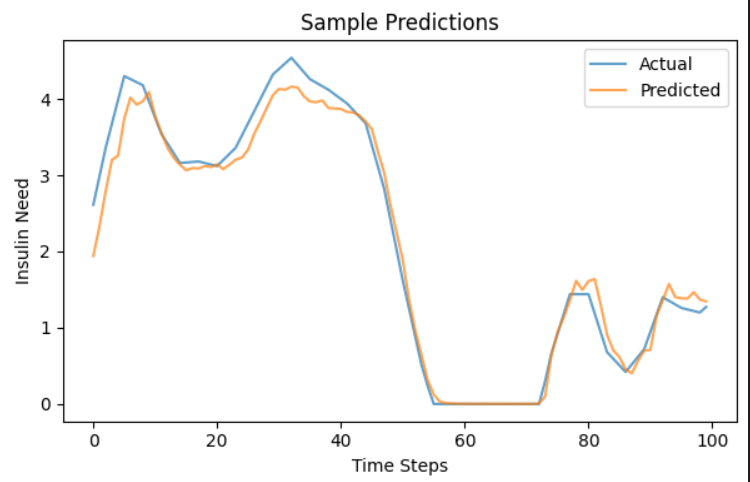